In [1]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install seaborn --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.15                  |              mkl          10 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py37hc8dfbb8_0         151 KB  conda-forge
    cpuonly-1.0                |                0           2 KB  pytorch
    freetype-2.10.2            |       he06d7ca_0         905 KB  conda-forge
    intel-openmp-2020.1        |              217         780 KB  defaults
    jpeg-9c                    |    h14c3975

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
%matplotlib inline

In [3]:
project_name='forest-fires-regression' # will be used by jovian.commit

In [5]:
df_raw = pd.read_csv('forestfires.csv')
df_raw.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [9]:
df = df_raw.drop(['X','Y','month','day','area','DMC','DC'], axis=1)
df.head()

,FFMC,ISI,temp,RH,wind,rain
0,86.2,5.1,8.2,51,6.7,0.0
1,90.6,6.7,18.0,33,0.9,0.0
2,90.6,6.7,14.6,33,1.3,0.0
3,91.7,9.0,8.3,97,4.0,0.2
4,89.3,9.6,11.4,99,1.8,0.0


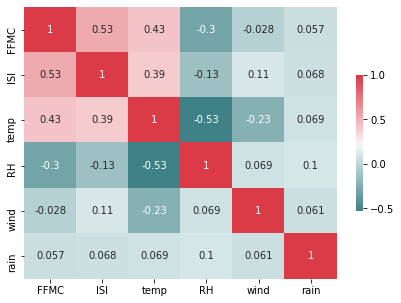

In [10]:
# Compute the correlation matrix
corr = df.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, cbar_kws={"shrink": .5})

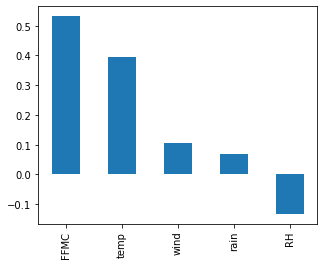

In [17]:
corr_with_isi = df.corr()['ISI'].sort_values(ascending=False)
plt.figure(figsize=(5,4))
corr_with_isi.drop('ISI').plot.bar()
plt.show();

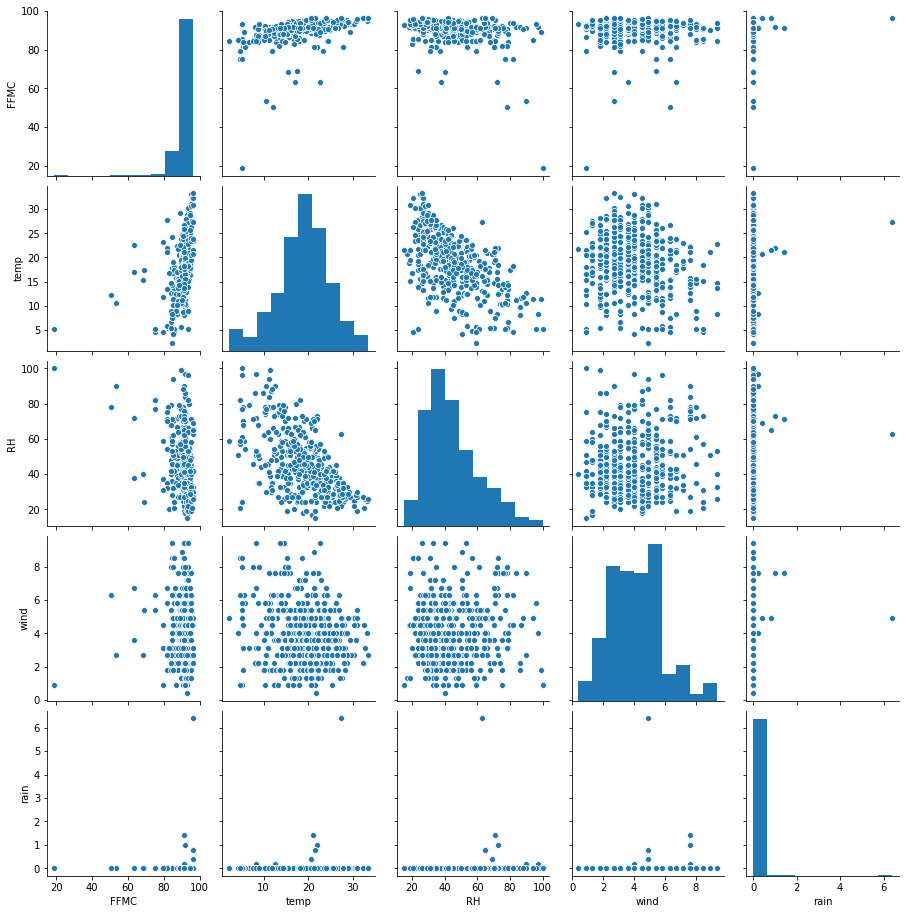

In [18]:
sns.pairplot(df[['FFMC', 'temp', 'RH', 'wind', 'rain']])
plt.show()

In [37]:
num_rows = df.shape[0]
num_cols = df.shape[1]
input_cols = ['FFMC','temp','RH','wind','rain']
output_cols = ['ISI']

In [38]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "allenkong221/forest-fires-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/allenkong221/forest-fires-regression


'https://jovian.ml/allenkong221/forest-fires-regression'

In [39]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep=True)
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [40]:
inputs_array, targets_array = dataframe_to_arrays(df)

In [41]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [42]:
dataset = TensorDataset(inputs, targets)

In [43]:
val_percent = 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size,val_size])

In [44]:
batch_size = 32

In [45]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [46]:
input_size = len(input_cols)
output_size = len(output_cols)

In [47]:
class FFModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 10th epoch
        if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [48]:
ffmodel = FFModel()

In [49]:
list(ffmodel.parameters())

[Parameter containing:
 tensor([[-0.2179,  0.2630,  0.2648, -0.3560,  0.4448]], requires_grad=True),
 Parameter containing:
 tensor([0.0781], requires_grad=True)]

In [33]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "allenkong221/forest-fires-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/allenkong221/forest-fires-regression


'https://jovian.ml/allenkong221/forest-fires-regression'

In [50]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [51]:
result = evaluate(ffmodel, val_loader)
print(result)

{'val_loss': 13.215707778930664}


In [55]:
epochs = 100
lr = 1e-4
history1 = fit(epochs, lr, ffmodel, train_loader, val_loader)

Epoch [10], val_loss: 8.8000
Epoch [20], val_loss: 7.1181
Epoch [30], val_loss: 5.5813
Epoch [40], val_loss: 4.2309
Epoch [50], val_loss: 3.1551
Epoch [60], val_loss: 2.6469
Epoch [70], val_loss: 2.4074
Epoch [80], val_loss: 2.3428
Epoch [90], val_loss: 2.3398
Epoch [100], val_loss: 2.3356


In [56]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [57]:
from random import sample

for i in sample(range(0,len(val_ds)),5):
    input, target = val_ds[i]
    predict_single(input, target, ffmodel)
    print()

Input: tensor([92.9000, 20.8000, 17.0000,  1.3000,  0.0000])
Target: tensor([9.2000])
Prediction: tensor([8.4695])

Input: tensor([84.9000,  4.2000, 51.0000,  4.0000,  0.0000])
Target: tensor([3.4000])
Prediction: tensor([2.7903])

Input: tensor([94.8000, 16.4000, 47.0000,  1.3000,  0.0000])
Target: tensor([17.])
Prediction: tensor([7.0918])

Input: tensor([92.9000, 27.7000, 24.0000,  2.2000,  0.0000])
Target: tensor([9.2000])
Prediction: tensor([11.2488])

Input: tensor([90.3000, 16.2000, 58.0000,  3.6000,  0.0000])
Target: tensor([7.4000])
Prediction: tensor([7.3676])



In [58]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "allenkong221/forest-fires-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/allenkong221/forest-fires-regression


'https://jovian.ml/allenkong221/forest-fires-regression'